In [267]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [225]:
datetime=get_datetime()
create_directory("dump/logs")
logfile = open("./dump/logs/log_{}.log".format(datetime), "w")
logfile=None

In [226]:
def constant_seed(seed: int = 0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
constant_seed()

In [227]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cprint(f"Using device: {device}", logfile)

18:28:06 | Using device: cpu


## Load data

In [228]:
data_root = "./data/two_multicells_two_moas/"
metadata_all = read_metadata(data_root + "metadata.csv")

mapping = get_MOA_mappings(metadata_all)

In [229]:
metadata_all.groupby(['moa'])['moa'].count()

moa
DMSO                       665
Microtubule stabilizers    258
Name: moa, dtype: int64

In [230]:
metadata = shuffle_metadata(metadata_all)
metadata_train_all, metadata_test = split_metadata(metadata, split_fraction = .90)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .90)

In [231]:
relative_path = get_relative_image_paths(metadata)
image_paths = [data_root + path for path in relative_path]

In [232]:
images = load_images(image_paths, verbose=True, log_every=10000)

18:28:07 | loaded 0/923 images (0.00%).
18:28:07 | loaded 923/923 images (100.00%).


## Normalize data

In [233]:
normalize_channels_inplace(images)
print(images.shape)

torch.Size([923, 3, 68, 68])


## Split data

In [234]:
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)
test_set = SingleCellDataset(metadata_test, images, mapping)

## Load trained model

In [235]:

vae, validation_data, training_data, VAE_settings = LoadVAEmodel("model_dump",'2022-11-23 - 22-21-58')


In [236]:
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference(beta=VAE_settings['beta'])

In [237]:
train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=VAE_settings['batch_size'], shuffle=False, num_workers=0, drop_last=False)


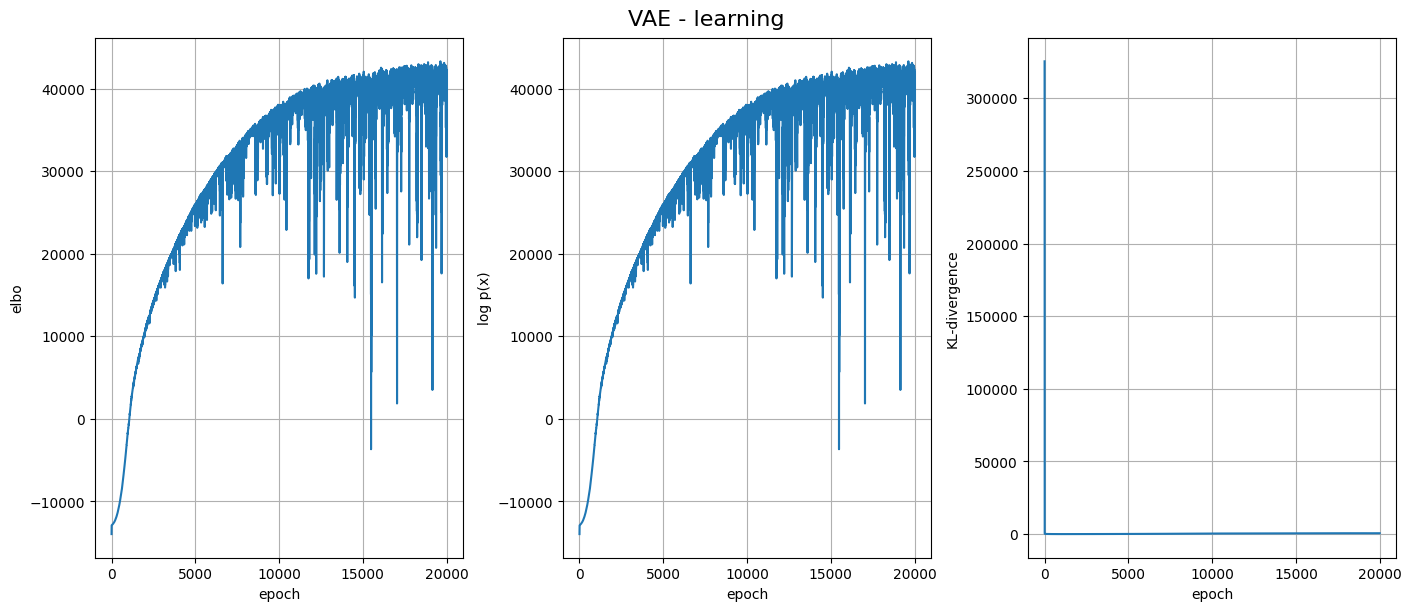

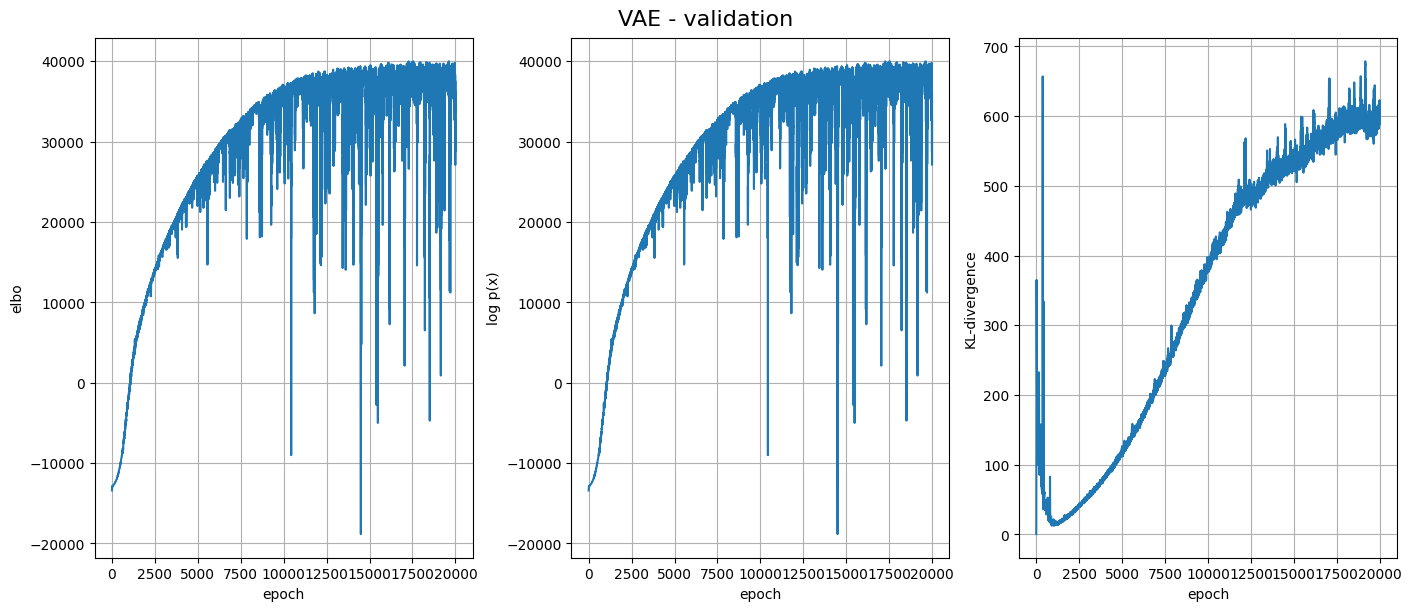

In [238]:
plot_VAE_performance(**training_data, title='VAE - learning')
plot_VAE_performance(**validation_data, title='VAE - validation')


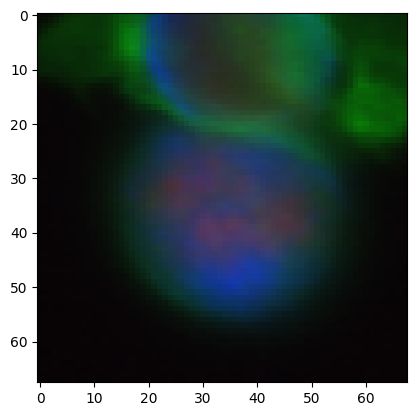

In [239]:
x, _y = test_set[2]
plot_image(x)

In [240]:
vae.eval() # because of batch normalization
outputs = vae(x[None,:,:,:])
px = outputs["px"]

x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]

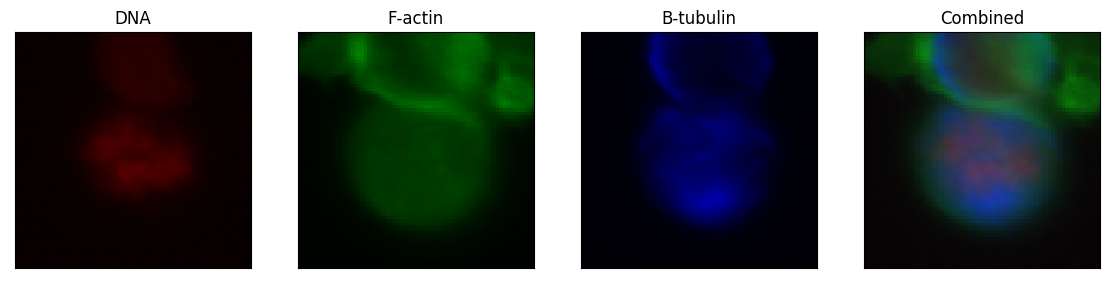

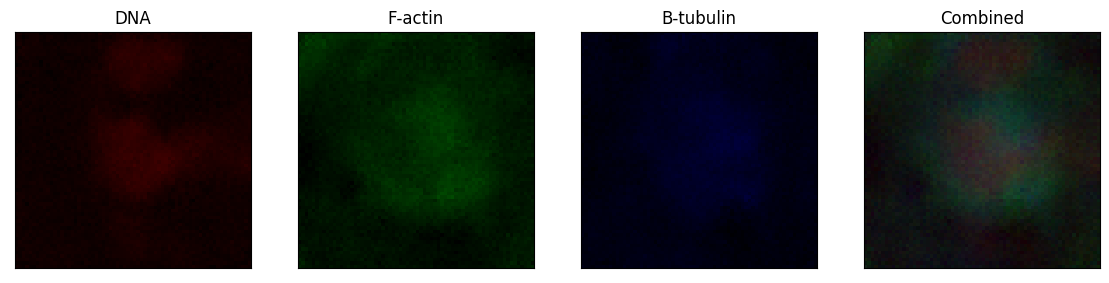

In [241]:
plot_image_channels(x)
plot_image_channels(x_reconstruction)

In [242]:
def img_saturate(img):
    return img / torch.max(img)

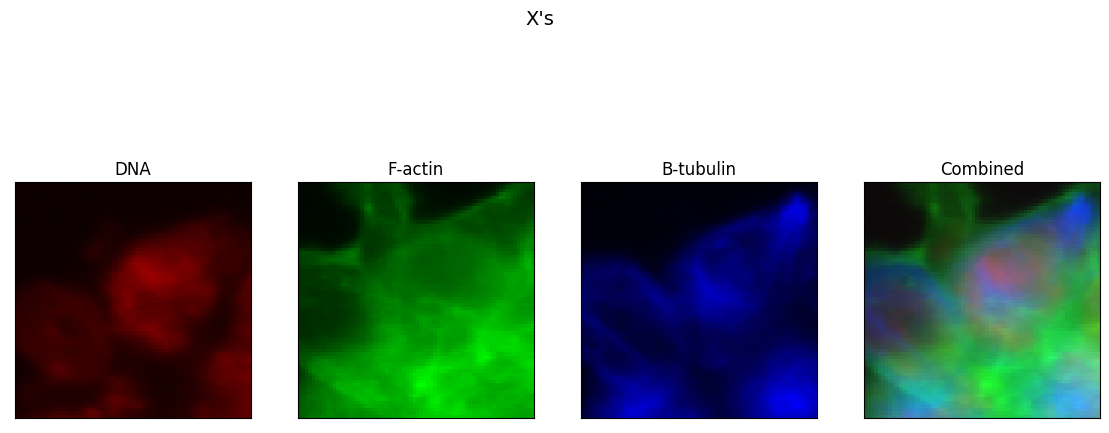

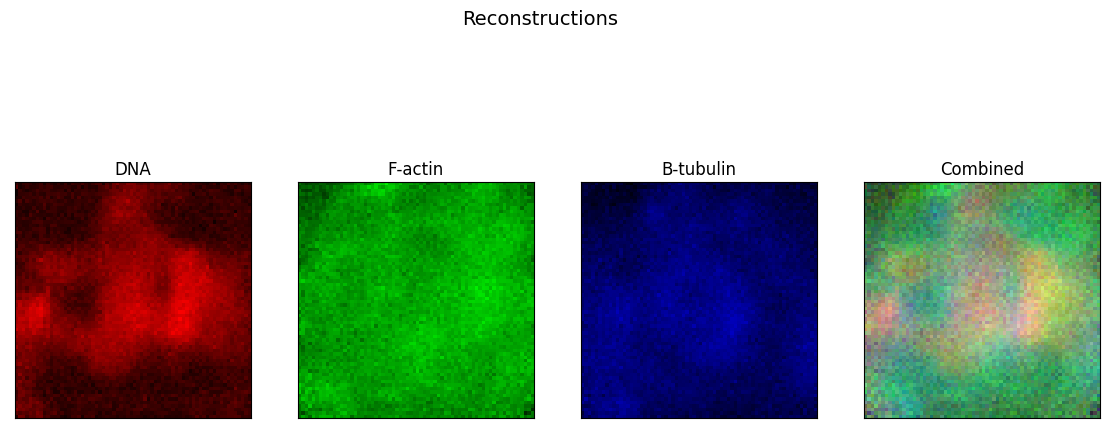

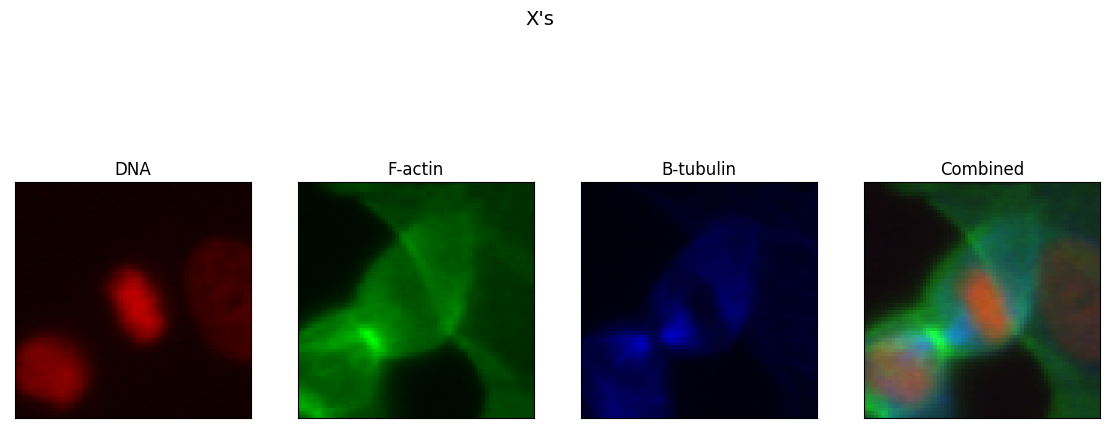

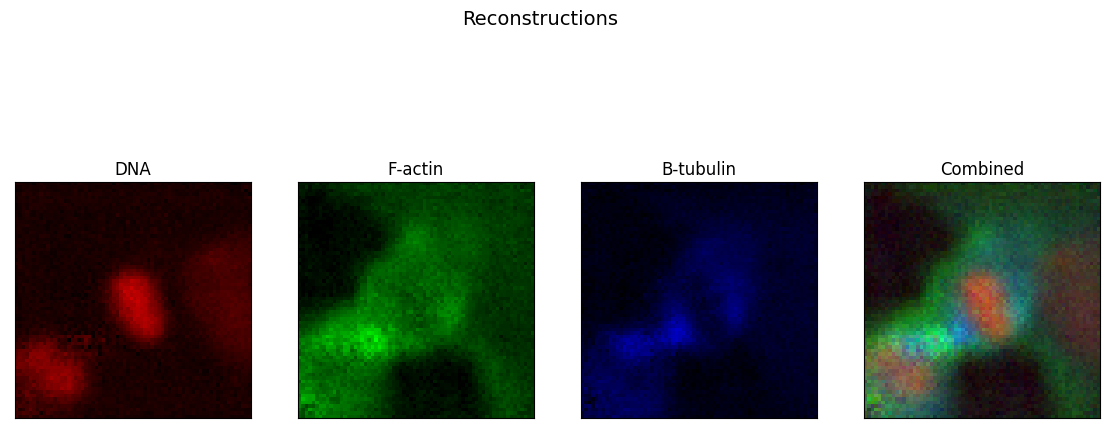

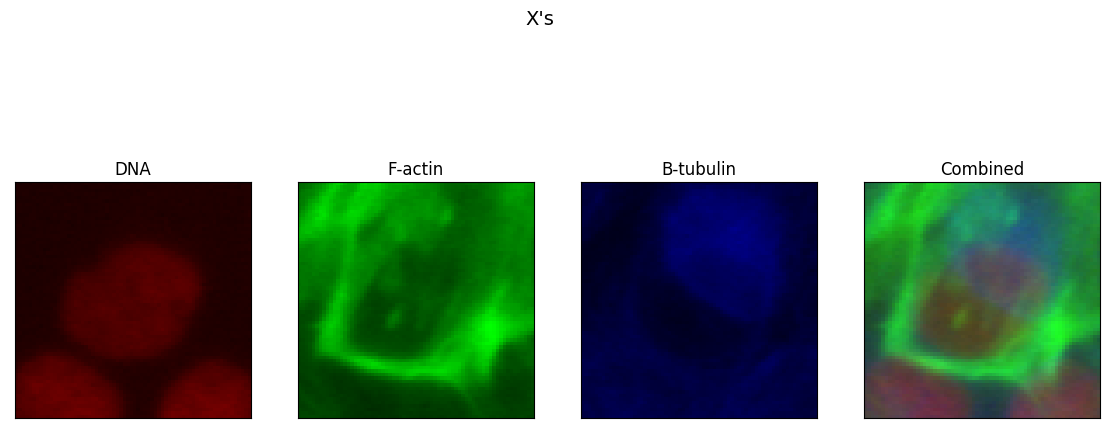

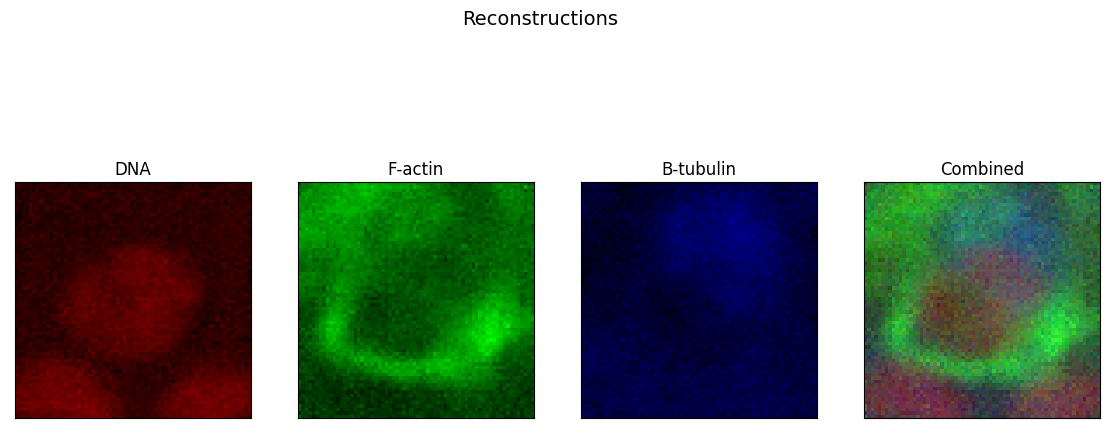

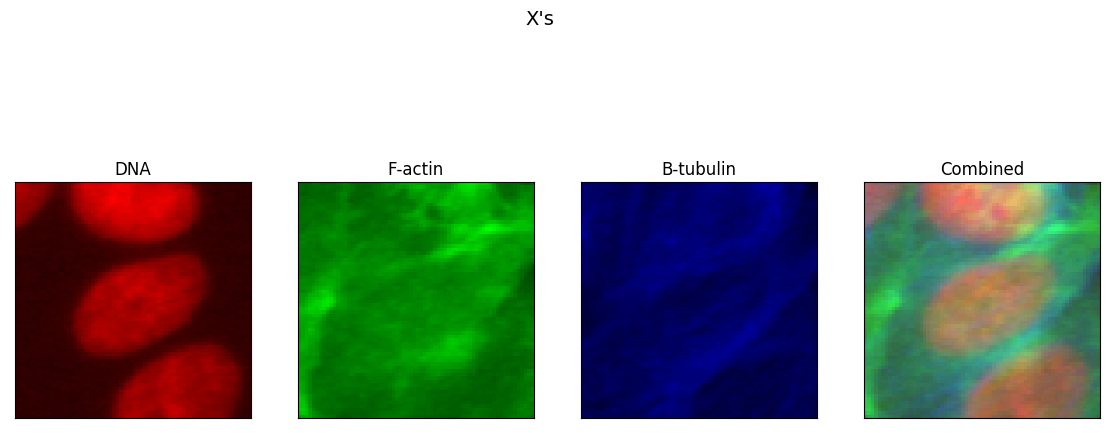

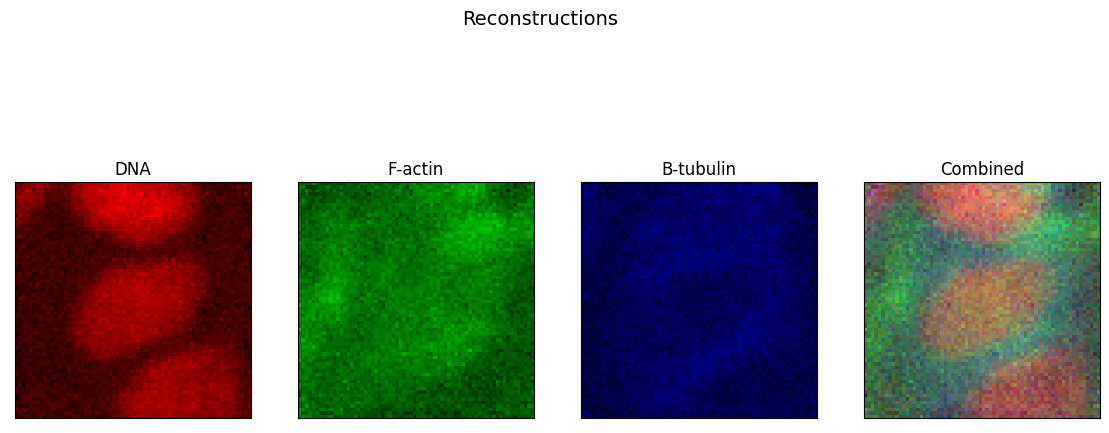

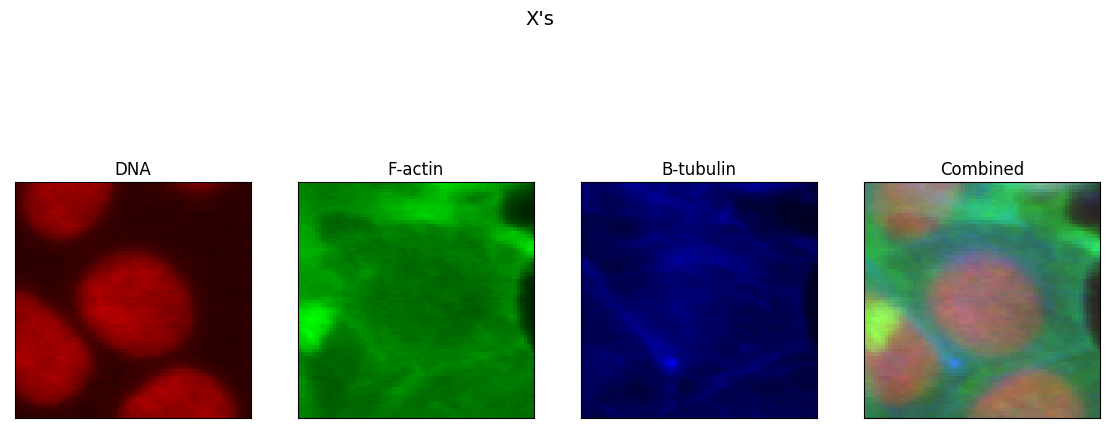

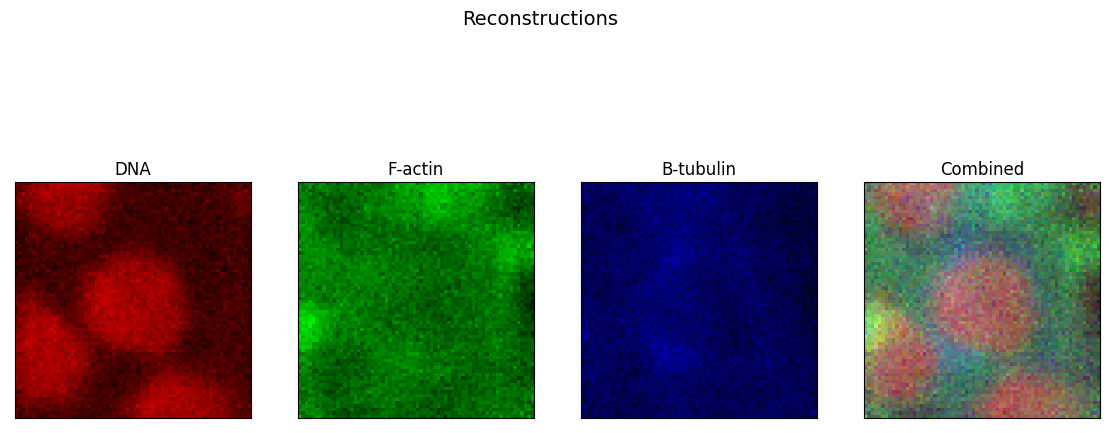

In [243]:
n = 5
for i in range(10,n+10):
    x, y = train_set[i]    
    #x = x.to(device)
    
    plot_image_channels(img_saturate(x), title="X's")
   
    outputs = vae(x[None,:,:,:])
    px = outputs["px"]
    
    x_reconstruction = px.sample()
    x_reconstruction = x_reconstruction[0]
    plot_image_channels(img_saturate(x_reconstruction), title="Reconstructions")


## Downstream Classification

In [244]:
VAE_settings

{'latent_features': 256,
 'beta': 1.0,
 'num_epochs': 20000,
 'batch_size': 512,
 'learning_rate': 0.001,
 'weight_decay': 0.001,
 'image_shape': array([ 3, 68, 68])}

In [245]:
class NeuralNetwork(nn.Module):
    
    def __init__(self,n_latent, n_classes: int = 13):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, n_classes),
            nn.BatchNorm1d(n_classes)
        )
        

    def forward(self, x):
        logits = self.net(x)
        return logits


N_latent = VAE_settings['latent_features']
N_classes = len(mapping)
classifier = NeuralNetwork(N_latent, N_classes).to(device)
print(classifier)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
    (7): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [246]:
# Classifier
classifier = NeuralNetwork(N_latent,N_classes).to(device)

# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2)

num_epochs = 100
batch_size = 32

In [247]:
def count_num_correct(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()

In [248]:
train_loss = []
train_accuracy = []

validation_loss = []
validation_accuracy = []
print_every = 10

for epoch in range(num_epochs):

    train_epoch_loss = []
    train_epoch_accuracy = []
    
    classifier.train()
    
    train_correct = 0
    train_num_predictions = 0
    
    for x, y in train_loader:
        x = x.to(device)
        
        outputs = vae(x)
        z = outputs["z"]
        
        prediction_prob = classifier(z)
        loss = loss_fn(prediction_prob, y)
        
        train_epoch_loss.append(loss.item())
        
        N = len(x)
        train_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        train_correct += count_num_correct(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_mean_loss = np.mean(train_epoch_loss)
    train_loss.append(epoch_mean_loss)
    train_accuracy.append(train_correct / train_num_predictions)
    
    validation_epoch_loss = []
    classifier.eval()
    
    validation_correct = 0
    validation_num_predictions = 0
    
    for x, y in validation_loader:
        x = x.to(device)
        
        outputs = vae(x)
        z = outputs["z"]
        
        prediction_prob = classifier(z)
        loss = loss_fn(prediction_prob, y)
        
        validation_epoch_loss.append(loss.item())
        
        N = len(x)
        validation_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        validation_correct += count_num_correct(pred, y)

    epoch_mean_loss = np.mean(validation_epoch_loss)
    validation_loss.append(epoch_mean_loss)
    validation_accuracy.append(validation_correct / validation_num_predictions)
   
    if epoch % print_every == 0:
        print(f"epoch: {epoch}/{num_epochs}")    
        print("training | loss: {:.2f}".format(epoch_mean_loss))
        print("validation | loss: {:.2f}".format(epoch_mean_loss))

epoch: 0/100
training | loss: 0.66
validation | loss: 0.66
epoch: 10/100
training | loss: 0.69
validation | loss: 0.69
epoch: 20/100
training | loss: 0.72
validation | loss: 0.72
epoch: 30/100
training | loss: 0.67
validation | loss: 0.67
epoch: 40/100
training | loss: 0.69
validation | loss: 0.69
epoch: 50/100
training | loss: 0.66
validation | loss: 0.66
epoch: 60/100
training | loss: 0.68
validation | loss: 0.68
epoch: 70/100
training | loss: 0.67
validation | loss: 0.67
epoch: 80/100
training | loss: 0.68
validation | loss: 0.68
epoch: 90/100
training | loss: 0.66
validation | loss: 0.66


In [249]:
def plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy):
    fig, axs = plt.subplots(1, 2, figsize=(14,6), constrained_layout = True)
    fig.suptitle("Classifier - learning", fontsize=16)

    ax1 = axs[0]
    ax1.grid()
    ax1.plot(train_loss)
    ax1.plot(validation_loss)
    ax1.legend(["train", "validation"])
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")

    ax2 = axs[1]
    ax2.grid()
    ax2.plot(train_accuracy)
    ax2.plot(validation_accuracy)
    ax2.legend(["train", "validation"])
    ax2.set_ylabel("accuracy")
    ax2.set_xlabel("epoch")

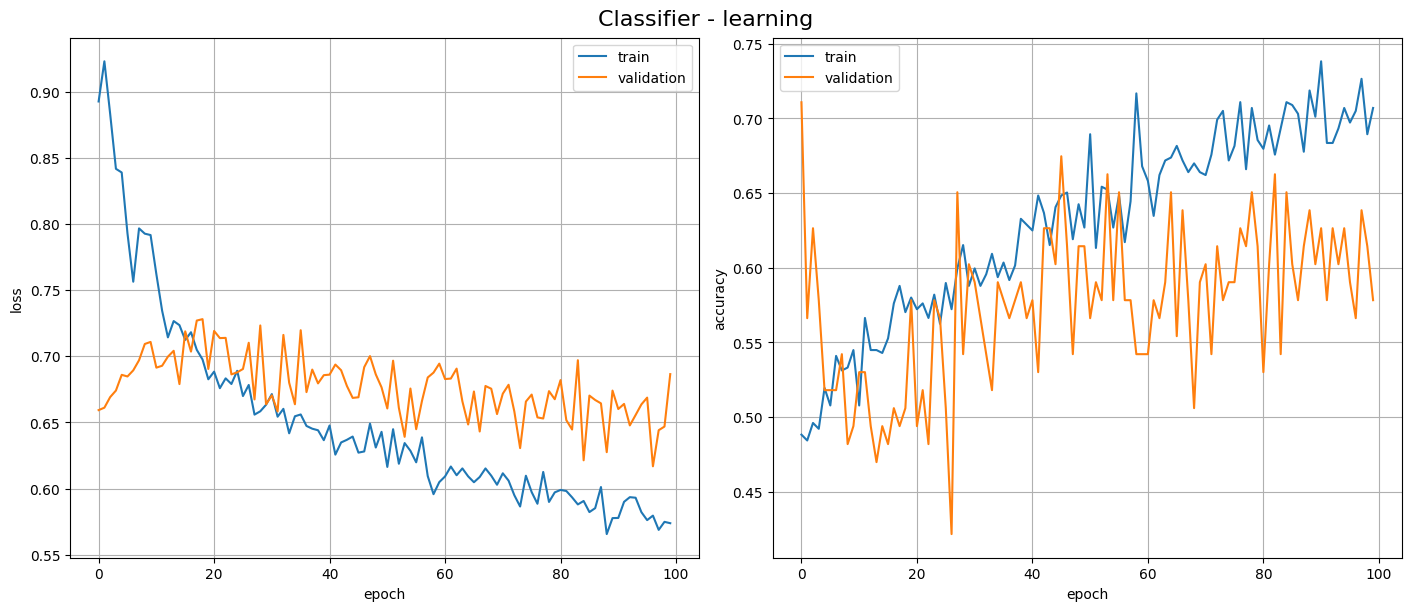

In [250]:
plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy)

In [276]:
def classifier_from_x(x):
    return classifier(vae(x[None,:,:,:])['z']).argmax()

Y_hat_set = [classifier_from_x(x).detach().numpy() for x,y in  train_set]
Y_set = [y for x,y in  train_set]

<AxesSubplot:>

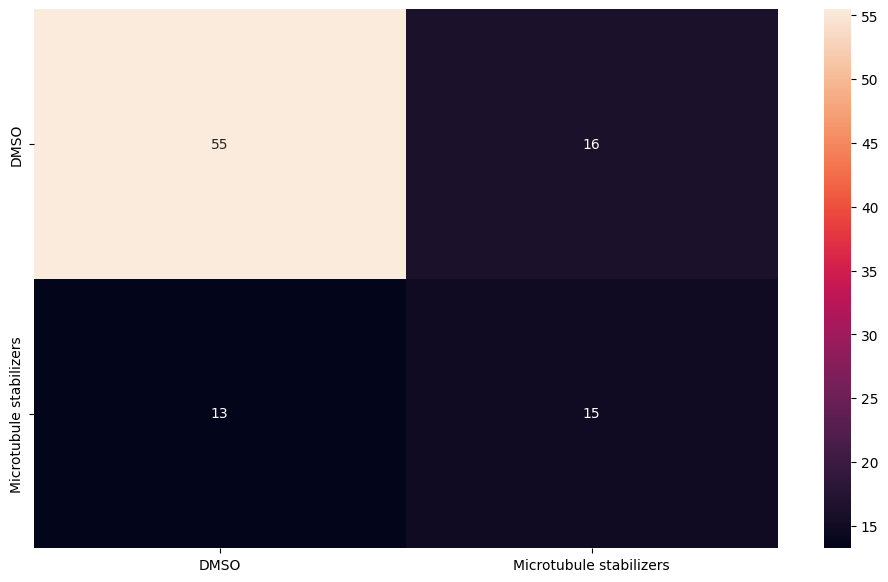

In [283]:
cf_matrix=confusion_matrix(Y_set, Y_hat_set)  
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in mapping],
                     columns = [i for i in mapping])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)


In [284]:
#for i, (x, y) in enumerate(train_set):
#    outputs = vae(x[None,:,:,:])
#    z = outputs['z']
#    #print(z.shape)
#    y_hat = classifier(z)
#    print(i, y, y_hat.argmax(), nn.functional.softmax(y_hat, dim=1).tolist())